## -MODEL 5 -

### 1. Setup and Load Data

##### 1.1 Install Dependencies and Setup

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16

In [ ]:
#KALAU PERANGKAT NYA PUNYA GPU
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

##### 1.2 Remove dodgy images

In [2]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [3]:
data_dir = 'DATA/IMAGES'

In [4]:
image_exts = ['jpeg', 'jpg', 'png']

In [24]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)

##### 1.3 Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = tf.keras.utils.image_dataset_from_directory('DATA/IMAGES/')

class_names = data.class_names
print(class_names)

Found 171 files belonging to 5 classes.
['Grade 1 (Tidak Rusak)', 'Grade 2 (Rusak Ringan)', 'Grade 3 (Rusak Sedang)', 'Grade 4 (Rusak Berat)', 'Grade 5 (Rusak Total)']


### .

In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
# Get another batch from the iterator
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 320, 320, 3)

In [13]:
# Class 0 = Grade 1 (Tidak Rusak)
# Class 1 = Grade 2 (Rusak Ringan)
# Class 2 = Grade 3 (Rusak Sedang)
# Class 3 = Grade 4 (Rusak Berat)
# Class 4 = Grade 5 (Rusak Total)

batch[1]

array([2, 2, 0, 3, 3, 0, 3, 0, 1, 0, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 1, 0,
       0, 1, 2, 0, 0, 1, 1, 3, 4, 2])

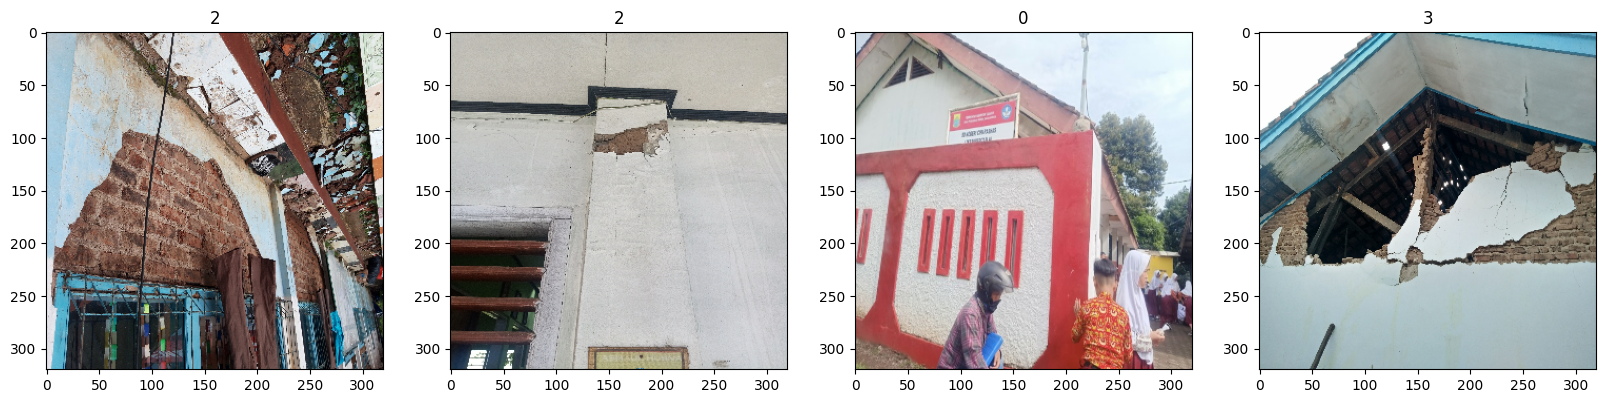

In [14]:
fig, ax = plt.subplots(ncols= 4, figsize= (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
batch[0]

array([[[[167.29    , 177.29    , 187.29    ],
         [189.72    , 200.52    , 206.62001 ],
         [179.75    , 190.75    , 196.75    ],
         ...,
         [233.25    , 238.3     , 234.3     ],
         [232.66988 , 236.66988 , 235.66988 ],
         [247.45088 , 252.82071 , 251.45088 ]],

        [[189.66    , 198.95999 , 207.95999 ],
         [185.98    , 195.98    , 204.98    ],
         [187.7     , 198.25    , 206.95    ],
         ...,
         [237.45    , 240.2     , 238.75    ],
         [236.5791  , 239.9791  , 238.9791  ],
         [227.67949 , 236.7795  , 229.0795  ]],

        [[187.6     , 197.6     , 206.6     ],
         [180.84999 , 193.55    , 202.65    ],
         [174.75    , 187.75    , 195.75    ],
         ...,
         [232.25    , 236.5     , 232.75    ],
         [219.50049 , 226.50049 , 219.50049 ],
         [197.29883 , 211.29883 , 198.29883 ]],

        ...,

        [[224.1     , 223.1     , 229.1     ],
         [229.90001 , 228.90001 , 234.90001 ]

### 2. Preprocess Data

##### 2.1 Scale Data

In [4]:
# Ubah fungsi map untuk mengubah nilai gambar dari 0 - 255 menjadi 0-1 dan 
# label menjadi one-hot encoding

data = data.map(lambda x, y: (x/255, tf.one_hot(y, depth= 5)))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch

(array([[[[0.48333332, 0.4990196 , 0.5029412 ],
          [0.5034314 , 0.50735295, 0.5151961 ],
          [0.5392157 , 0.5392157 , 0.5392157 ],
          ...,
          [0.56911767, 0.5534314 , 0.5416667 ],
          [0.54264706, 0.5387255 , 0.5230392 ],
          [0.52254903, 0.51862746, 0.5107843 ]],
 
         [[0.50735295, 0.5230392 , 0.51911765],
          [0.49313724, 0.49313724, 0.4852941 ],
          [0.52892154, 0.52892154, 0.52205884],
          ...,
          [0.5323529 , 0.52843136, 0.5127451 ],
          [0.54558825, 0.5416667 , 0.52205884],
          [0.53088236, 0.5348039 , 0.5151961 ]],
 
         [[0.4872549 , 0.50686276, 0.48333332],
          [0.50686276, 0.5147059 , 0.49509802],
          [0.5132353 , 0.5210784 , 0.50147057],
          ...,
          [0.54558825, 0.5416667 , 0.52254903],
          [0.5240196 , 0.52009803, 0.5122549 ],
          [0.5377451 , 0.53382355, 0.5181373 ]],
 
         ...,
 
         [[0.09656863, 0.32009804, 0.43382353],
          [0.13676

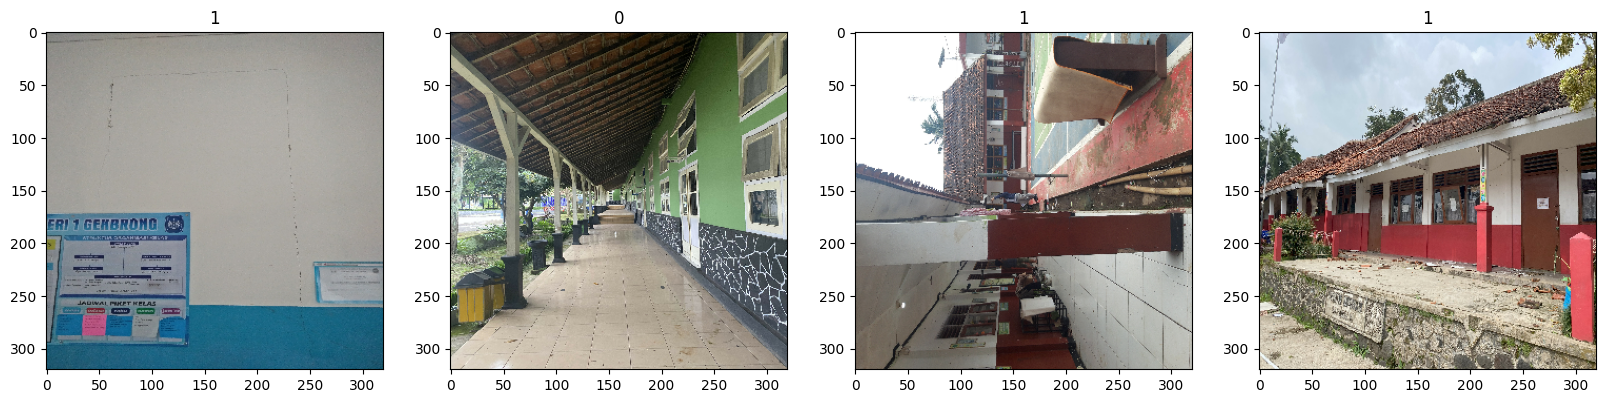

In [20]:
fig, ax = plt.subplots(ncols= 4, figsize= (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(np.argmax(batch[1][idx])) # Ubah label one-hot encoding kembali ke label asli untuk visualisasi

##### 2.2 Augmentasi Data

In [28]:
import cv2
import albumentations as A

# Define augmentation function
def apply_augmentations(image):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5), # Flipping the images horizontally
        A.Rotate(limit=10, p=0.5), # Rotating the images
        A.RandomBrightnessContrast(p=0.5), # Adjusting the brightness and contrast
        A.GaussianBlur(blur_limit=(3, 7), p=0.5), # Applying Gaussian blur
    ])

    augmented = transform(image=image)
    image = augmented['image']
    return image

# Set paths
input_folder = 'DATA/IMAGES/'
output_folder = 'DATA/augmented7/'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get list of grades
grades = ['Grade 1 (Tidak Rusak)', 'Grade 2 (Rusak Ringan)', 'Grade 3 (Rusak Sedang)', 'Grade 4 (Rusak Berat)', 'Grade 5 (Rusak Total)']

# Set the number of augmented images you want to create for each original image
num_augmented_images = 20

# Apply augmentations and save images
for grade in grades:
    grade_folder = os.path.join(input_folder, grade)
    output_grade_folder = os.path.join(output_folder, grade)

    # Create output grade folder if it doesn't exist
    os.makedirs(output_grade_folder, exist_ok=True)

    for filename in os.listdir(grade_folder):
        if filename.endswith('.jpg'):
            # Load image
            image_path = os.path.join(grade_folder, filename)
            image = cv2.imread(image_path)

            # Resize and normalize image, then convert to float32
            image = cv2.resize(image, (320, 320))
            image = (image / 255.0).astype(np.float32)

            for i in range(num_augmented_images):
                # Apply augmentations
                augmented_image = apply_augmentations(image)

                # Create a new filename for the augmented image
                base_filename = os.path.splitext(filename)[0]
                new_filename = f'augmented_{base_filename}_{i}.jpg'

                # Save augmented image
                output_image_path = os.path.join(output_grade_folder, new_filename)
                cv2.imwrite(output_image_path, (augmented_image * 255).astype(np.uint8))

In [36]:
augmented_image

array([[[0.99124086, 0.9564213 , 0.90544087],
        [0.9907737 , 0.9557997 , 0.90481937],
        [0.99027425, 0.9551302 , 0.9041498 ],
        ...,
        [0.816949  , 0.7597785 , 0.7123191 ],
        [0.81207466, 0.7566593 , 0.70947814],
        [0.8102641 , 0.7553071 , 0.7082306 ]],

       [[0.9905389 , 0.95603925, 0.90505916],
        [0.990365  , 0.9556073 , 0.90462714],
        [0.9902303 , 0.9552008 , 0.90422046],
        ...,
        [0.81689143, 0.7596078 , 0.71227854],
        [0.81206036, 0.75661665, 0.70947534],
        [0.81033176, 0.75537467, 0.7083039 ]],

       [[0.98361033, 0.9493963 , 0.89841706],
        [0.984836  , 0.9502713 , 0.8992916 ],
        [0.98625016, 0.9513273 , 0.90034705],
        ...,
        [0.81678796, 0.7594065 , 0.71221536],
        [0.8120069 , 0.75654566, 0.70944875],
        [0.8103709 , 0.7554194 , 0.70835656]],

       ...,

       [[0.24105145, 0.08585729, 0.03471859],
        [0.23562104, 0.08560035, 0.03486396],
        [0.22241384, 0

##### 2.3 Split Data

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(data_path, train_ratio, test_ratio, val_ratio):
    partitions = ['Grade 1 (Tidak Rusak)', 'Grade 2 (Rusak Ringan)', 'Grade 3 (Rusak Sedang)', 'Grade 4 (Rusak Berat)', 'Grade 5 (Rusak Total)']

    for partition in partitions:
        images_path = os.path.join(data_path, partition)

        # Get list of images
        images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

        # Split the images into training, testing, and validation sets
        train_images, test_images = train_test_split(images, test_size=test_ratio + val_ratio, random_state=50)
        test_images, val_images = train_test_split(test_images, test_size=val_ratio / (test_ratio + val_ratio), random_state=50)

        # Create directories for the dataset
        train_dir = os.path.join('F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/train_aug6', partition)
        test_dir = os.path.join('F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/test_aug6', partition)
        val_dir = os.path.join('F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/val_aug6', partition)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # Move the images to the appropriate directories
        for image in train_images:
            src = os.path.join(images_path, image)
            dst = os.path.join(train_dir, image)
            shutil.copyfile(src, dst)

        for image in test_images:
            src = os.path.join(images_path, image)
            dst = os.path.join(test_dir, image)
            shutil.copyfile(src, dst)

        for image in val_images:
            src = os.path.join(images_path, image)
            dst = os.path.join(val_dir, image)
            shutil.copyfile(src, dst)

split_data('F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/augmented7', 0.7, 0.15, 0.15)

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set paths
train_dir = 'F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/train_aug6'
test_dir = 'F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/test_aug6'
val_dir = 'F:/MAHARANI/MBKM/mypy/CNN/Building Damage Detection/DATA/val_aug6'

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, label_mode='categorical', image_size=(320,320), batch_size = 24)  # ubah batch_size disini   #kalau img_size bukan 256, harus atur sndiri mau size berapa
test_dataset = image_dataset_from_directory(test_dir, label_mode='categorical', image_size=(320,320), batch_size= 24)
val_dataset = image_dataset_from_directory(val_dir, label_mode='categorical', image_size=(320,320), batch_size= 24)

# Apply the function to the datasets
train_dataset = train_dataset.map(lambda x, y: (x/255, y))
test_dataset = test_dataset.map(lambda x, y: (x/255, y))
val_dataset = val_dataset.map(lambda x, y: (x/255, y))

Found 2394 files belonging to 5 classes.
Found 513 files belonging to 5 classes.
Found 513 files belonging to 5 classes.


In [39]:
# Ambil satu batch dari dataset
x, y = next(iter(train_dataset))

# Cetak nilai x dan y
print("Nilai x (images):")
print(x)
print("\nNilai y (labels):")
print(y)


Nilai x (images):
tf.Tensor(
[[[[2.44056374e-01 2.00919122e-01 1.30330876e-01]
   [2.75183827e-01 2.32046574e-01 1.61458328e-01]
   [2.97549009e-01 2.54411757e-01 1.83823526e-01]
   ...
   [2.54350483e-01 2.16053918e-01 1.83394611e-01]
   [2.79779404e-01 1.92463234e-01 1.52450979e-01]
   [2.84007341e-01 1.67830884e-01 1.24693625e-01]]

  [[2.53921568e-01 2.15196073e-01 1.43137261e-01]
   [2.83884794e-01 2.43504897e-01 1.71997547e-01]
   [3.09313715e-01 2.66176462e-01 1.95588231e-01]
   ...
   [2.59681374e-01 2.15686277e-01 1.82291672e-01]
   [2.75306374e-01 1.84129909e-01 1.44301474e-01]
   [2.98774511e-01 1.80024505e-01 1.36887252e-01]]

  [[2.61274517e-01 2.29901955e-01 1.55392155e-01]
   [2.90318638e-01 2.54534304e-01 1.81495100e-01]
   [3.09620112e-01 2.66482830e-01 1.95894614e-01]
   ...
   [2.53247559e-01 2.03737751e-01 1.66973040e-01]
   [2.78063715e-01 1.84436277e-01 1.42769605e-01]
   [3.08272064e-01 1.84926465e-01 1.41789213e-01]]

  ...

  [[6.06372535e-01 5.94607830e-01 5.5

##### 2.4 View Augmented Images

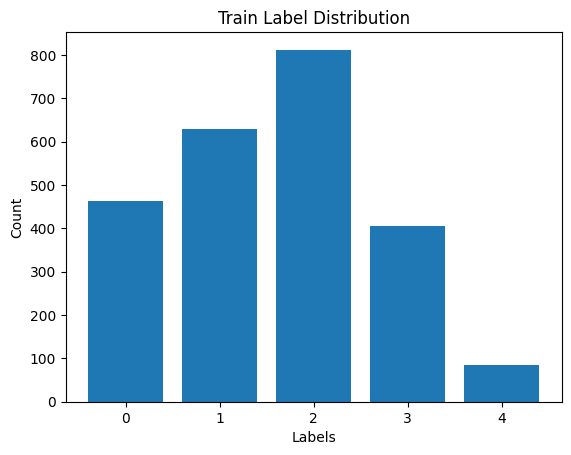

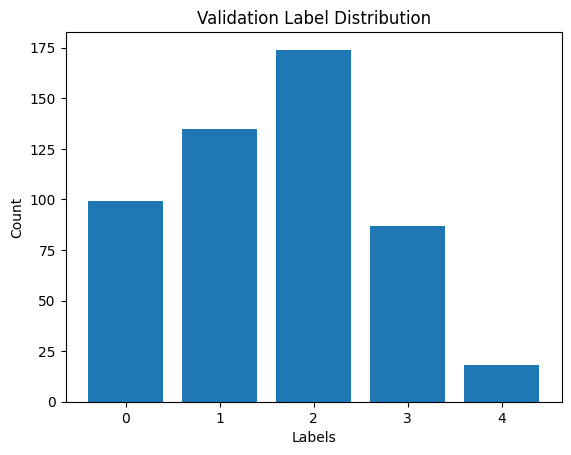

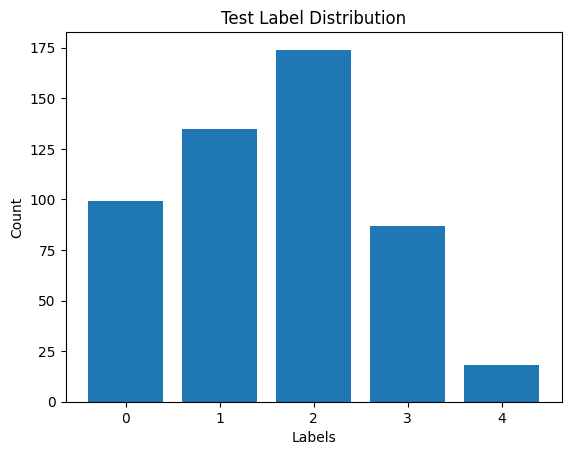

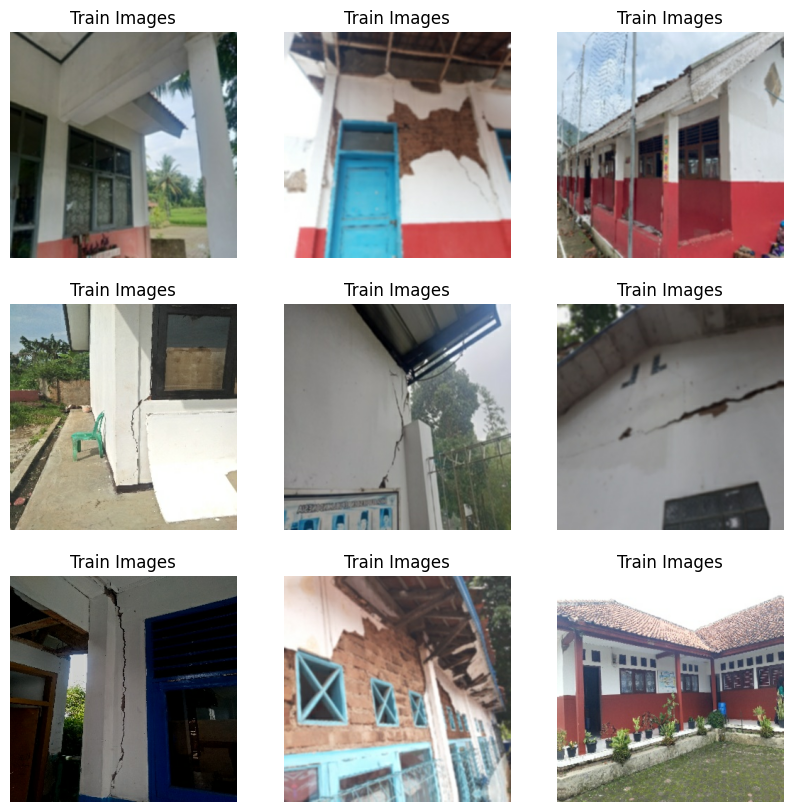

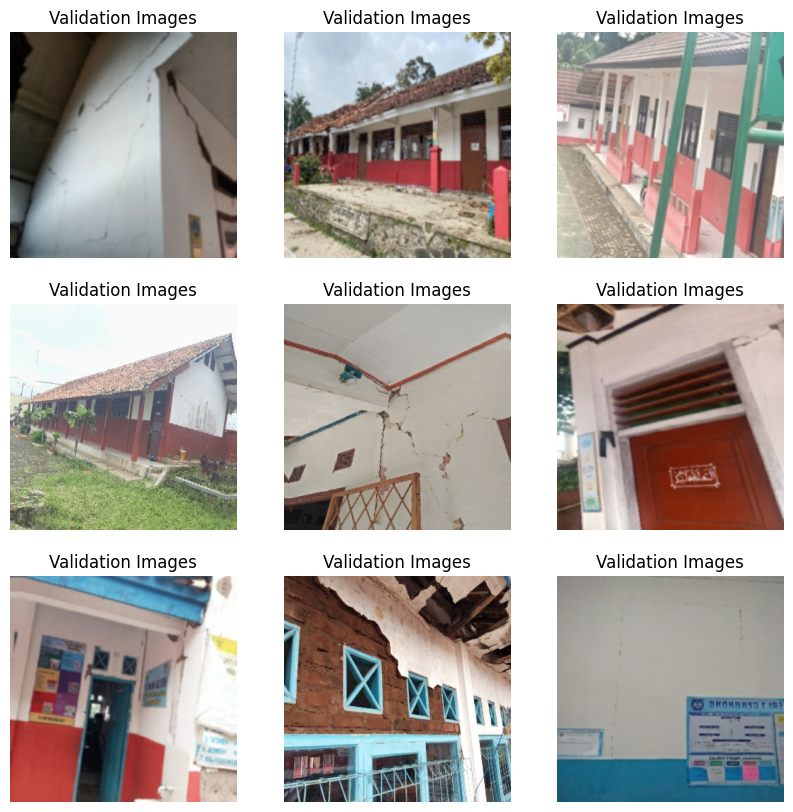

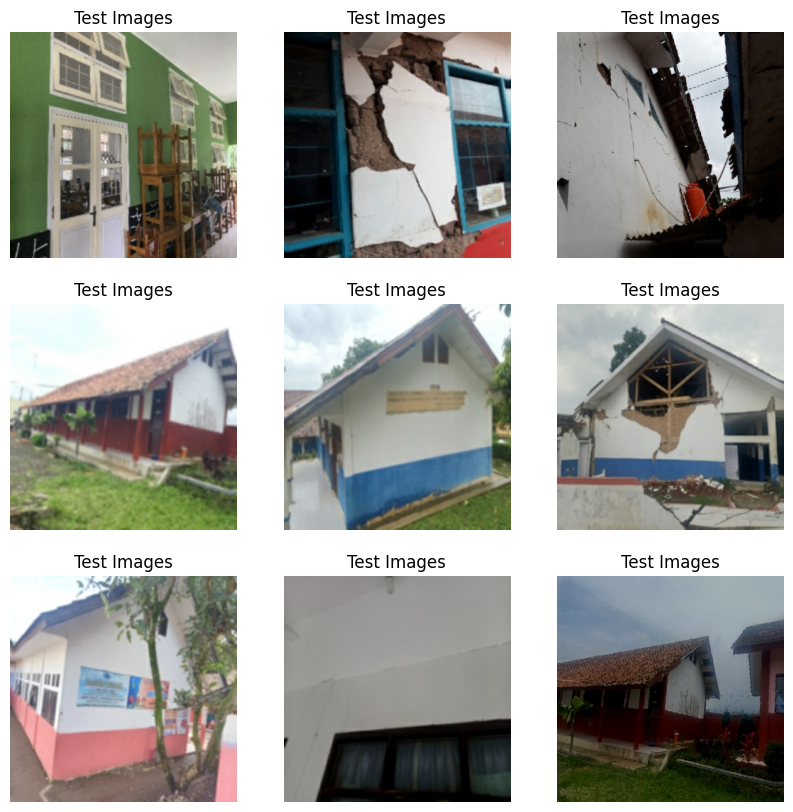

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot distribution of labels
def plot_label_distribution(dataset, title):
    # Get labels from dataset
    labels = []
    for _, label in dataset:
        labels.extend(np.argmax(label.numpy(), axis=1))

    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

# Plot label distribution for train, validation, and test sets
plot_label_distribution(train_dataset, 'Train Label Distribution')
plot_label_distribution(val_dataset, 'Validation Label Distribution')
plot_label_distribution(test_dataset, 'Test Label Distribution')

# Function to display images
def display_images(dataset, title):
    # Get first batch of images from dataset
    images, _ = next(iter(dataset))

    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        # Ensure the image is within the correct range
        image = np.clip(images[i].numpy(), 0, 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display images for train, validation, and test sets
display_images(train_dataset, 'Train Images')
display_images(val_dataset, 'Validation Images')
display_images(test_dataset, 'Test Images')


### 3. Depp Model

##### 3.1 Build Deep Learning Model

In [28]:

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

def make_model(metrics=METRICS):
  # Load the VGG16 network, ensuring the head FC layer sets are left off
  baseModel = VGG16(include_top=False, input_shape=(320, 320, 3))
  model = Sequential([
    baseModel,
    Conv2D(64, (3,3), strides = 1, activation= 'relu'),
    MaxPooling2D(pool_size= (2,2), strides= 2),
    Conv2D(32, (1,1), strides = 1, activation= 'relu'),
    MaxPooling2D(pool_size= (2,2), strides= 2),
    Flatten(),                                      # Menambahkan layer Flatten
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')                   # Menggunakan softmax untuk klasifikasi multikelas
  ])
  # Fine-tuning: Unfreeze the last convolution block of VGG16
  for layer in baseModel.layers:
      if layer.name.startswith('block5'):
          layer.trainable = True
      else:
          layer.trainable = False

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=metrics)

  return model

In [29]:
EPOCHS = 40

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

logdir = 'logs4.2 (VGG16, nolabel)'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)


In [30]:
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 32)          2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 128)              

In [31]:
from sklearn.utils import class_weight
import numpy as np

# Assuming that `train_labels` is a 2-D array containing the one-hot encoded class labels
# Convert one-hot encoded labels to class labels
train_labels = []
for _, label in train_dataset:
    train_labels.extend(np.argmax(label.numpy(), axis=1))

# Calculate the class weights
weights = class_weight.compute_sample_weight('balanced', train_labels)
class_weights = dict(enumerate(weights))


##### 3.2 Train

In [32]:
model = make_model()

baseline_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, early_stopping],
    validation_data= val_dataset,
    class_weight= class_weights)

Epoch 1/40
100/100 [==============================] - 620s 6s/step - loss: 1.2572 - tp: 386.0000 - fp: 375.0000 - tn: 9201.0000 - fn: 2008.0000 - accuracy: 0.3847 - precision: 0.5072 - recall: 0.1612 - val_loss: 1.1320 - val_tp: 203.0000 - val_fp: 127.0000 - val_tn: 1925.0000 - val_fn: 310.0000 - val_accuracy: 0.5283 - val_precision: 0.6152 - val_recall: 0.3957
Epoch 2/40
100/100 [==============================] - 618s 6s/step - loss: 0.5887 - tp: 1546.0000 - fp: 394.0000 - tn: 9182.0000 - fn: 848.0000 - accuracy: 0.7193 - precision: 0.7969 - recall: 0.6458 - val_loss: 0.3502 - val_tp: 440.0000 - val_fp: 44.0000 - val_tn: 2008.0000 - val_fn: 73.0000 - val_accuracy: 0.8850 - val_precision: 0.9091 - val_recall: 0.8577
Epoch 3/40
100/100 [==============================] - 625s 6s/step - loss: 0.2368 - tp: 2109.0000 - fp: 167.0000 - tn: 9409.0000 - fn: 285.0000 - accuracy: 0.8972 - precision: 0.9266 - recall: 0.8810 - val_loss: 0.2605 - val_tp: 458.0000 - val_fp: 28.0000 - val_tn: 2024.000

##### 3.3 Plot Performance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(15, 13))
    data = {}  # Dictionary to store metric values for each epoch
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)

        #Menghapus bingkai 'atas' dan 'kanan' di setiap subplot
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.plot([epoch + 1 for epoch in history.epoch], history.history[metric], color= 'blue', label='Train')
        plt.plot([epoch + 1 for epoch in history.epoch], history.history['val_'+metric],
                 color= 'orange', linestyle="--", label='Val')
        plt.xlabel('Epoch', fontsize=14)  # Set font size for x-axis label
        plt.ylabel(name, fontsize=14)  # Set font size for y-axis label
        plt.tick_params(axis='both', which='major', labelsize=13)  # Set font size for numbers on x and y axis
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        legend = plt.legend()
        plt.setp(legend.get_texts(), fontsize=13)  # Set font size for legend

        # Store metric values in the dictionary
        data[f'train_{metric}'] = history.history[metric]
        data[f'val_{metric}'] = history.history['val_'+metric]

    plt.subplots_adjust(hspace=0.7, wspace=0.7)  # Adjust the spacing between subplots
    plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding

    # Create a DataFrame from the dictionary and save it as a CSV file
    df = pd.DataFrame(data)
    df.to_csv('metrics classes model 5.csv', index=False)

plot_metrics(baseline_history)


### 4. Evaluate Performance

##### 4.1 Evaluate

In [34]:
# Pisahkan gambar dari label
train_images = train_dataset.map(lambda image, label: image)
train_labels = train_dataset.map(lambda image, label: label)
test_images = test_dataset.map(lambda image, label: image)
test_labels = test_dataset.map(lambda image, label: label)

# Lakukan prediksi pada gambar saja
train_predictions_baseline = model.predict(train_images, batch_size=24)
test_predictions_baseline = model.predict(test_images, batch_size=24)


22/22 [==============================] - 94s 4s/step


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(labels, predictions, threshold=0.5):
  # Konversi one-hot encoded labels ke label kelas
  class_labels = np.argmax(labels, axis=1)

  # Konversi prediksi ke label kelas berdasarkan ambang batas
  class_predictions = np.argmax(predictions, axis=1)
  thresholded_predictions = [1 if pred > threshold else 0 for pred in class_predictions]

  cm = confusion_matrix(class_labels, thresholded_predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
from sklearn.metrics import classification_report

# Evaluasi model
print("Evaluate on test data")
results = model.evaluate(test_dataset)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

# Dapatkan label dari test_dataset
test_labels = []
for _, labels in test_dataset:
    test_labels.extend(labels.numpy())
test_labels = np.array(test_labels)

# Ubah test_labels dari one-hot encoding menjadi multiclass
test_labels2 = np.argmax(test_labels, axis=1)

# Prediksi label dari test_dataset
test_predictions = np.argmax(test_predictions_baseline, axis=1)  # Mengubah probabilitas menjadi label

# Cetak classification report
print("Classification Report")
print(classification_report(test_labels2, test_predictions))

# Plot confusion matrix
print("Confusion Matrix")
plot_cm(test_labels, test_predictions_baseline)


##### 4.2 Test

In [35]:
import cv2

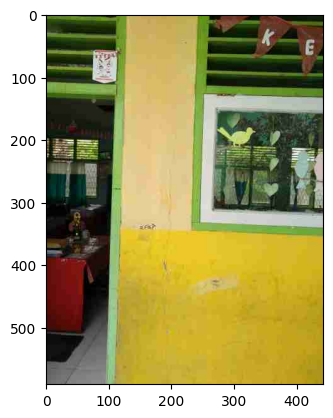

In [36]:
img_test = cv2.imread('Sekolah/PALU (28 SEP 2018)/2344.jpg')
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.show()

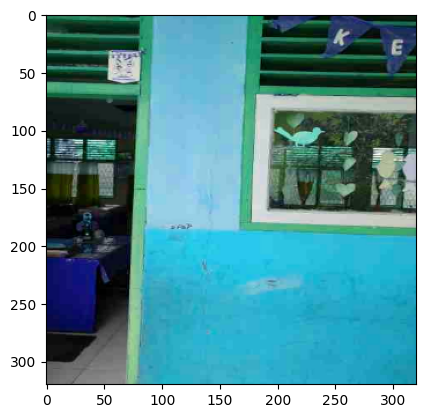

In [37]:
resize = tf.image.resize(img_test,(320,320))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
resize.shape

TensorShape([320, 320, 3])

In [39]:
np.expand_dims(resize, 0)

array([[[[  3.8109374,  84.126564 ,  47.126564 ],
         [  3.8109374,  84.126564 ,  47.126564 ],
         [  3.8109374,  84.126564 ,  47.126564 ],
         ...,
         [  1.4234375,  42.153126 ,  25.576563 ],
         [  1.4234375,  42.153126 ,  25.576563 ],
         [  1.4234375,  42.153126 ,  25.576563 ]],

        [[ 34.97735  , 124.54063  ,  88.54063  ],
         [ 34.85233  , 124.54063  ,  88.54063  ],
         [ 34.561745 , 124.54063  ,  88.54063  ],
         ...,
         [  4.561743 ,  39.189064 ,  23.459375 ],
         [  4.8523316,  39.189064 ,  23.459375 ],
         [  4.977341 ,  39.189064 ,  23.459375 ]],

        [[ 38.650646 , 125.46875  ,  89.58594  ],
         [ 38.446495 , 125.46875  ,  89.58594  ],
         [ 37.971985 , 125.46875  ,  89.58594  ],
         ...,
         [  9.53772  ,  33.648438 ,  19.765625 ],
         [ 10.486753 ,  33.648438 ,  19.765625 ],
         [ 10.895022 ,  33.648438 ,  19.765625 ]],

        ...,

        [[108.       , 108.       , 10

In [40]:
# Prediksi kelas
yhat = model.predict(np.expand_dims(resize/255, 0))
predicted_class = np.argmax(yhat)

1/1 [==============================] - 0s 452ms/step


In [41]:
predicted_class

2

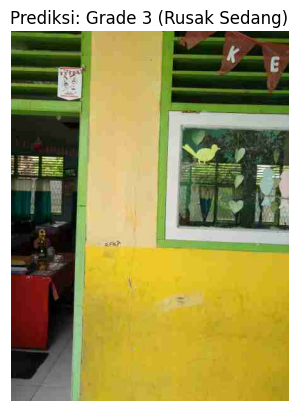

In [42]:
# Menampilkan gambar
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Menampilkan prediksi kelas
if predicted_class == 0:
    plt.title("Prediksi: Grade 1 (Tidak Rusak)")
elif predicted_class == 1:
    plt.title("Prediksi: Grade 2 (Rusak Ringan)")
elif predicted_class == 2:
    plt.title("Prediksi: Grade 3 (Rusak Sedang)")
elif predicted_class == 3:
    plt.title("Prediksi: Grade 4 (Rusak Berat)")
elif predicted_class == 4:
    plt.title("Prediksi: Grade 5 (Rusak Total)")
else:
    plt.title("Prediksi tidak diketahui")

plt.show()

### 5. Save the Model

##### 5.1 Save the Model

In [37]:
# Save the model
model.save('damageclassifier_versi4.2.1_noLABELLING_VGG16.h5')

f:\MAHARANI\MBKM\mypy\CNN\Building Damage Detection\bdetect\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
